### This notebook transform the data similar to how I transform data using SQL in dbt folder

Initialize spark session

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import to_date, date_format, col, when
from datetime import datetime


# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read CSV with PySpark") \
    .getOrCreate()

In [4]:
# Read CSV file into DataFrame

schema = StructType([
    StructField("player", StringType(), True),
    StructField("date", StringType(), True),
    StructField("club", StringType(), True),
    # Add more fields as needed
])


players = spark.read.csv("data/players.csv", schema=schema)

In [5]:
# Display DataFrame schema
players.printSchema()

# Display first few rows of DataFrame
players.show()

root
 |-- player: string (nullable = true)
 |-- date: string (nullable = true)
 |-- club: string (nullable = true)

+------------------+------------+-------+
|            player|        date|   club|
+------------------+------------+-------+
|   JORDAN PICKFORD| Jul 1, 2017|Everton|
|     JOÃO VIRGÍNIA| Jul 1, 2020|Everton|
|     ANDY LONERGAN|Aug 20, 2021|Everton|
|JARRAD BRANTHWAITE|Jan 13, 2020|Everton|
|   JAMES TARKOWSKI| Jul 2, 2022|Everton|
|       BEN GODFREY| Oct 5, 2020|Everton|
|     MICHAEL KEANE| Jul 3, 2017|Everton|
| VITALIY MYKOLENKO| Jan 1, 2022|Everton|
|      ASHLEY YOUNG|Jul 13, 2023|Everton|
|  NATHAN PATTERSON| Jan 4, 2022|Everton|
|    SEAMUS COLEMAN| Jan 1, 2009|Everton|
|      AMADOU ONANA| Aug 9, 2022|Everton|
|      JAMES GARNER| Sep 1, 2022|Everton|
|ABDOULAYE DOUCOURÉ| Sep 8, 2020|Everton|
|       ANDRÉ GOMES| Jul 1, 2019|Everton|
|     IDRISSA GUEYE| Sep 1, 2022|Everton|
|     TYLER ONYANGO| Jul 1, 2023|Everton|
|         DELE ALLI|Jan 31, 2022|Everton|
| 

### handle the dates

In [6]:
players = players.withColumn("date", to_date(players["date"], "MMM d, yyyy"))

In [7]:
players = players.orderBy("date")
players.show()

+--------------------+----------+-----------------+
|              player|      date|             club|
+--------------------+----------+-----------------+
|         BOBBY CLARK|      NULL|        Liverpool|
| KAINE KESLER-HAYDEN|      NULL|      Aston Villa|
|     ALFIE GILCHRIST|      NULL|          Chelsea|
|      CESARE CASADEI|      NULL|          Chelsea|
|      SEAMUS COLEMAN|2009-01-01|          Everton|
|          LEWIS DUNK|2010-07-01|         Brighton|
|           JOEL WARD|2012-07-01|   Crystal Palace|
|        PAUL DUMMETT|2012-07-01|        Newcastle|
|         SOLLY MARCH|2013-07-01|         Brighton|
|          ADAM SMITH|2014-01-28|      Bournemouth|
|PELLY RUDDOCK MPANZU|2014-01-28|            Luton|
|           LUKE SHAW|2014-07-01|          Man Utd|
|        CHRIS BASHAM|2014-07-01| Sheffield United|
|     AARON CRESSWELL|2014-07-03|         West Ham|
|          BEN DAVIES|2014-07-23|Tottenham Hotspur|
|    JAMAAL LASCELLES|2014-08-09|        Newcastle|
|         TO

### read in manager data

In [8]:
manager_schema = StructType([
    StructField("manager", StringType(), True),
    StructField("start", StringType(), True),
    StructField("end", StringType(), True),
    StructField("club", StringType(), True),
    # Add more fields as needed
])


managers = spark.read.option("header", "true").csv("data/managers.csv", schema=manager_schema)
managers = managers.withColumn("start", to_date(managers["start"], "dd MMM, yyyy"))
managers = managers.withColumn("end", to_date(managers["end"], "dd MMM, yyyy"))
managers = managers.withColumn("end", when(col("end").isNull(), datetime.today().date()).otherwise(col("end")))

managers.show()

+-----------------+----------+----------+-------+
|          manager|     start|       end|   club|
+-----------------+----------+----------+-------+
|     Mikel Arteta|2019-12-22|2024-03-14|Arsenal|
|Fredrik Ljungberg|2019-11-29|2019-12-22|Arsenal|
|       Unai Emery|2018-05-23|2019-11-29|Arsenal|
|    Arsene Wenger|1996-09-30|2018-05-14|Arsenal|
|         Pat Rice|1996-09-16|1996-09-30|Arsenal|
|  Stewart Houston|1996-08-12|1996-09-16|Arsenal|
|      Bruce Rioch|1995-06-08|1996-08-12|Arsenal|
|  Stewart Houston|1995-02-21|1996-06-08|Arsenal|
|    George Graham|1986-05-14|1995-02-21|Arsenal|
| Steve Burtenshaw|1986-03-25|1986-05-14|Arsenal|
|         Don Howe|1983-12-16|1986-03-22|Arsenal|
|      Terry Neill|1976-07-08|1983-12-16|Arsenal|
|       Bertie Mee|1966-06-01|1976-05-04|Arsenal|
|     Billy Wright|1962-05-01|1966-06-01|Arsenal|
|   George Swindin|1958-07-01|1962-05-01|Arsenal|
|    Jack Crayston|1956-11-01|1958-05-01|Arsenal|
|    Tom Whittaker|1947-06-01|1956-10-01|Arsenal|


## join using sql

In [16]:
players.createOrReplaceTempView("players")
managers.createOrReplaceTempView("managers")

# Perform SQL join operation
data = spark.sql("""
    SELECT players.player, players.club, managers.manager
    FROM players 
    left join managers
    on players.club = managers.club and players.date >= managers.start and players.date < managers.end
   
""").orderBy("player")

data.show(5)

+-----------------+---------+--------------------+
|           player|     club|             manager|
+-----------------+---------+--------------------+
|  AARON CRESSWELL| West Ham|       Sam Allardyce|
|     AARON HICKEY|Brentford|        Thomas Frank|
|   AARON RAMSDALE|  Arsenal|        Mikel Arteta|
|     AARON RAMSEY|  Burnley|     Vincent Kompany|
|AARON WAN-BISSAKA|  Man Utd|Ole Gunnar Solskjaer|
+-----------------+---------+--------------------+
only showing top 5 rows



In [77]:
agg_df = data.groupBy("club", "manager").count().orderBy("club")

# Convert to Pandas DataFrame for visualization
pandas_df = agg_df.toPandas()

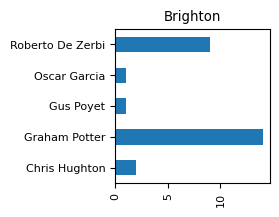

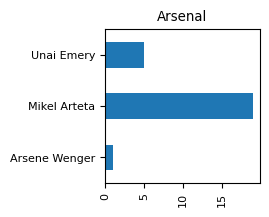

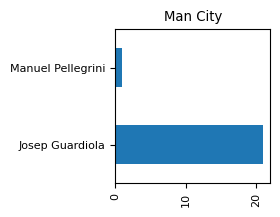

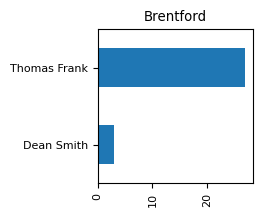

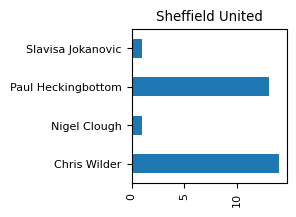

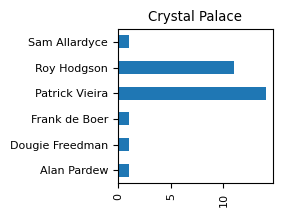

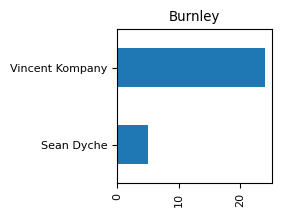

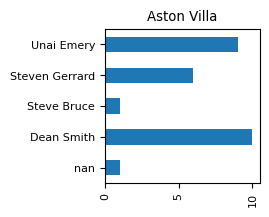

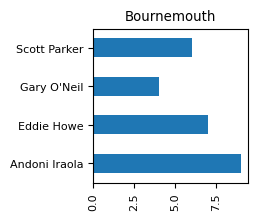

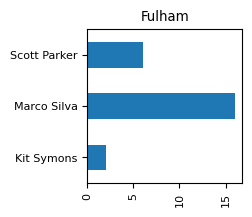

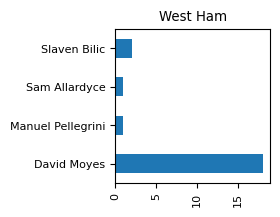

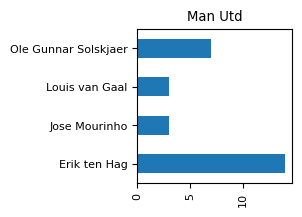

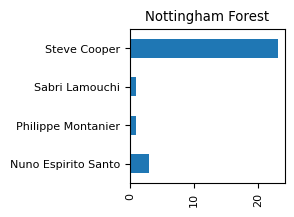

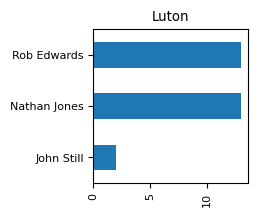

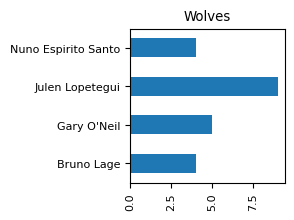

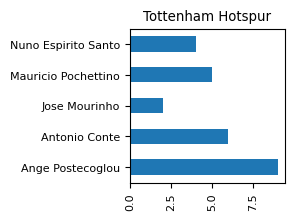

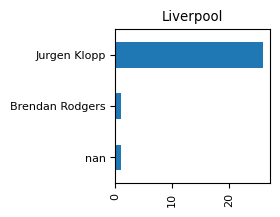

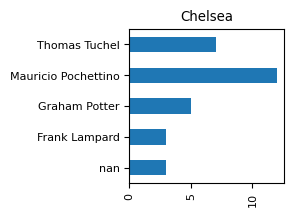

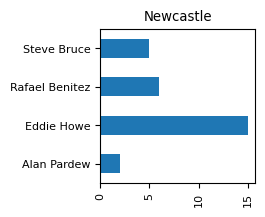

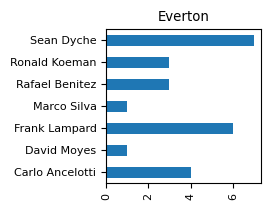

In [91]:
teams = agg_df.select("club").distinct().rdd.flatMap(lambda x: x).collect()
plt.rcParams.update({'font.size': 8})
for x in teams:
    rslt_df = pandas_df[pandas_df['club'] == x] 
    rslt_df.pivot(index="manager", columns="club", values="count").plot.barh(figsize=(2,2))
    plt.title(x)
    plt.ylabel(None)
    plt.xticks(rotation=90)
    plt.legend().set_visible(False)
    plt.show()